In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
import scipy
from sklearn.multioutput import MultiOutputRegressor
from scipy.io import loadmat
import ast
from sklearn.decomposition import PCA
from toolz.curried import unique
import seaborn as sns
import matplotlib.pyplot as plt
from utils.helpers import select_descriptors, read_embeddings


In [2]:
def custom_ridge_regression(X, y):
    linreg = RidgeCV()
    linreg = MultiOutputRegressor(linreg,n_jobs=-1)
    estimator = linreg.fit(X, y)
    return estimator

In [3]:
def metrics_per_descriptor(X, y, linreg):
 
    """
    Calculate predictions, mean squared errors, and Pearson correlations for each descriptor.

    Parameters:
    X (array-like): Input features.
    y (array-like): True target values.
    linreg (object): Linear regression model with a predict method.

    Returns:
    tuple: A tuple containing predicted values, a list of MSEs, and a list of correlations.
    """
    predicted = linreg.predict(X)
    
    # Ensure y is 2D for consistent iteration
    y = y if len(y.shape) > 1 else y.reshape(-1, 1)
    predicted = predicted if len(predicted.shape) > 1 else predicted.reshape(-1, 1)
    
    

    mse_errors = [mean_squared_error(predicted[:, i], y[:, i]) for i in range(y.shape[1])]
    correlations = [scipy.stats.pearsonr(predicted[:, i], y[:, i]) for i in range(y.shape[1])]
    spearman_correlations = [scipy.stats.spearmanr(predicted[:, i], y[:, i]) for i in range(y.shape[1])]
    return predicted, mse_errors, correlations,spearman_correlations

In [4]:
def train_and_eval_ntimes(X,y, times,n_components=None):
    """
    Train and evaluate a regression model using cross-validation.

    Parameters:
    data (DataFrame): Input data containing embeddings and fmri_average.
    times (int): Number of cross-validation iterations.
    n_components (int, optional): Number of components for dimensionality reduction.

    Returns:
    tuple: Contains CIDs, predicted values, test targets, runs, MSE errors, and correlations.
    """
    mse_errors_crossvalidated = []
    correlations_crossvalidated = []
    spearman_crossvalidated = []
    predicteds = []
    y_tests = []
    runs_predictions = []
    runs_metrics = []
    voxels = []
    voxels_predicteds = []
    for i in range(times):
        print(f"Processing run {i}")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed + i
        )
        if n_components:
            pca = PCA(n_components=n_components)
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)
            

        linreg = custom_ridge_regression(X_train, y_train)
        predicted, mse_errors, correlations,spearman_correlation = metrics_per_descriptor(X_test, y_test, linreg)


        #flatten the predicted and y_test arrays
        voxels_predicted = np.arange(predicted.shape[1])
        predicted = np.concatenate(predicted)
        y_test_flatten = np.concatenate(y_test)
        mse_errors_crossvalidated.extend(mse_errors)
        correlations_crossvalidated.extend(correlations)
        spearman_crossvalidated.extend(spearman_correlation)
        predicteds.extend(predicted)
        y_tests.extend(y_test_flatten)
        
        runs_metrics.extend([i] * y_test.shape[1])
        runs_predictions.extend([i] * y_test.shape[0]*y_test.shape[1])
        
        voxels.extend(np.arange(y.shape[1]))
        
        voxels_predicted = np.repeat(voxels_predicted,y_test.shape[0])
        voxels_predicteds.extend(voxels_predicted)
      
    return predicteds, y_tests, runs_metrics,runs_predictions, mse_errors_crossvalidated, correlations_crossvalidated,spearman_crossvalidated,voxels,voxels_predicteds

In [5]:
def pipeline(X,y, times=30,n_components=None):
    """
    Run the pipeline for a specific voxel and model, processing fMRI and embeddings data.

    Parameters:
    fmri_ev (DataFrame): fMRI event data.
    voxel (int): The voxel identifier.
    model_name (str): Name of the model being evaluated.
    input_file (str): Path to the input CSV file.
    times (int, optional): Number of cross-validation iterations. Default is 30.
    n_components (int, optional): Number of components for dimensionality reduction. Default is None.

    Returns:
    tuple: DataFrames containing predictions and metrics.
    """
    # Filter voxel-specific data
    
    

    # Train and evaluate the model
    results = train_and_eval_ntimes(X,y, times=times,n_components=n_components)
    predicteds, y_tests, runs_metrics,runs_predictions, mse_errors, correlations,spearman_correlations,targets,targets_predicteds = results
    predicteds = np.asarray(predicteds)
    y_tests = np.asarray(y_tests)
   
    runs_metrics = np.asarray(runs_metrics)
    runs_predictions = np.asarray(runs_predictions)
    mse_errors = np.asarray(mse_errors)
    correlations = np.asarray(correlations)
    spearman_correlations = np.asarray(spearman_correlations)
    targets = np.asarray(targets)
    targets_predicteds = np.asarray(targets_predicteds)

    mse_errors = np.asarray(mse_errors)
    correlations = np.asarray(correlations)

    
    stats_correlations = correlations[:, 0]
    pvalues_correlations = correlations[:, 1]
    
    stats_spearman_correlations = spearman_correlations[:, 0]
    pvalues_spearman_correlations = spearman_correlations[:, 1]
    

    
    metrics_df = pd.DataFrame(
        np.column_stack([stats_correlations, pvalues_correlations, mse_errors,targets,stats_spearman_correlations,pvalues_spearman_correlations,runs_metrics]),
        columns=['pearson_correlation', 'pearson_pvalue', 'mse','voxel','spearman_correlation','spearman_pvalue','run']
    )
    
    predictions_df = pd.DataFrame(
        np.column_stack([predicteds, y_tests,targets_predicteds,runs_predictions]),
        columns=['predicted', 'target', 'voxel','run']
    )

    return predictions_df, metrics_df

In [6]:
def compute_correlation(X,y,n_components=None):
    """
    Compute correlations for MolFormer across specified layers and voxels.

    Parameters:
    times (int): Number of cross-validation iterations.
    n_components (int): Number of components for dimensionality reduction.
    fmri_ev (DataFrame): fMRI event data.
    input_file_molformer (str): Base path for MolFormer input files.
    layers (list, optional): List of layers to process. Default is [13].

    Returns:
    tuple: Metrics and predictions for MolFormer.
    """

    df_predictions_molformer, df_metric_molformer = pipeline(X,
        y, times=30,n_components=n_components)

    df_metric_molformer["subject"]=subject
    df_predictions_molformer["subject"]=subject

    return df_predictions_molformer, df_metric_molformer


# Load embeddings

In [7]:


#define all these parameters
i = 1000
dataset_name = 'sagarfmri'
data_type = 'representation'
representation_name = 'fmri'
batch_size = 160
lr = 0.1
seed = 1
model_name = 'contrastive'
latent_dist_fun = 'poincare'
distance_method = 'euclidean'
temperature = 0.1
n_neighbors = 20
epsilon = 10.0
roi = 'AMY'
subject = 1


# Regression for Sagar or Keller dataset

## X is defined as embeeddigns and y can be either Continues behavioral ratings or dragon features

In [8]:
y_type = 'ratings'
# y_type = 'dragon_features'
dataset = 'sagar'
# dataset = 'keller'
if y_type not in ['ratings','dragon_features']:
    raise ValueError("y_type must be either 'ratings' or 'dragon_features'")
if dataset not in ['sagar','keller']:
    raise ValueError("dataset must be either 'sagar' or 'keller'")
y = np.load(f'data/{dataset}/{y_type}_{subject}.npy')

In [9]:
df_metrics_all = pd.DataFrame()
for roi in ['AMY','OFC','PirF','PirT']:
    X=np.load(f"data/subject1/fMRI/{roi}/embeddings_{i}_{dataset_name}_{data_type}_{representation_name}_{batch_size}_"f"{lr}_{seed}_{model_name}_{latent_dist_fun}_{distance_method}_{temperature}_{n_neighbors}_{epsilon}_{roi}_{subject}.npy")
    df_predictions, df_metric = compute_correlation(X,y,n_components=None)

    df_metric['roi'] = roi
    X_random = np.random.rand(X.shape[0],X.shape[1])
    df_predictions_random , df_metric_random = compute_correlation(X_random,y,n_components=None)

    df_metric_random['roi'] = roi+'_random'
    df_metrics_all = pd.concat([df_metrics_all,df_metric_random])
    df_metrics_all = pd.concat([df_metrics_all,df_metric])

Processing run 0
Processing run 1
Processing run 2
Processing run 3
Processing run 4
Processing run 5
Processing run 6
Processing run 7
Processing run 8
Processing run 9
Processing run 10
Processing run 11
Processing run 12
Processing run 13
Processing run 14
Processing run 15
Processing run 16
Processing run 17
Processing run 18
Processing run 19
Processing run 20
Processing run 21
Processing run 22
Processing run 23
Processing run 24
Processing run 25
Processing run 26
Processing run 27
Processing run 28
Processing run 29
Processing run 0
Processing run 1
Processing run 2
Processing run 3
Processing run 4
Processing run 5
Processing run 6
Processing run 7
Processing run 8
Processing run 9
Processing run 10
Processing run 11
Processing run 12
Processing run 13
Processing run 14
Processing run 15
Processing run 16
Processing run 17
Processing run 18
Processing run 19
Processing run 20
Processing run 21
Processing run 22
Processing run 23
Processing run 24
Processing run 25
Processing r

In [10]:
#define all these parameters
i = 1000
dataset_name = 'sagar'
data_type = 'representation'
representation_name = 'molformer'
batch_size = 160
lr = 0.1
seed = 1
model_name = 'contrastive'
latent_dist_fun = 'poincare'
distance_method = 'euclidean'
temperature = 0.1
n_neighbors = 20
epsilon = 10.0
roi = 'None'
subject = 1
X=np.load(f"data/subject1/{representation_name}/embeddings_{i}_{dataset_name}_{data_type}_{representation_name}_{batch_size}_"f"{lr}_{seed}_{model_name}_{latent_dist_fun}_{distance_method}_{temperature}_{n_neighbors}_{epsilon}_{roi}_{subject}.npy")
base_dir = 'data/'
input_embeddings = f'embeddings/{representation_name}/{dataset_name}_{representation_name}_embeddings_13_Apr17.csv'
        # embeddings, labels,subjects,CIDs = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings,
        #                                      grand_avg=True if dataset_name == 'keller' else False)
embeddings, labels,subjects,CIDs = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings,
                                             grand_avg=True if dataset_name == 'keller' or dataset_name=='sagar' else False)
CIDs_1 = pd.read_csv(f'data/{dataset}/CIDs_smiles_{subject}.csv')
indices = np.where( np.isin(CIDs.cpu().numpy(), CIDs_1['CIDs'].values))[0]
X = X[indices]
df_predictions, df_metric = compute_correlation(X,y,n_components=None)#gran
df_metric['roi'] = 'MolFormer'
df_metrics_all = pd.concat([df_metrics_all,df_metric])


Processing run 0
Processing run 1
Processing run 2
Processing run 3
Processing run 4
Processing run 5
Processing run 6
Processing run 7
Processing run 8
Processing run 9
Processing run 10
Processing run 11
Processing run 12
Processing run 13
Processing run 14
Processing run 15
Processing run 16
Processing run 17
Processing run 18
Processing run 19
Processing run 20
Processing run 21
Processing run 22
Processing run 23
Processing run 24
Processing run 25
Processing run 26
Processing run 27
Processing run 28
Processing run 29


In [11]:
i = 1000
dataset_name = 'sagar'
data_type = 'representation'
representation_name = 'pom'
batch_size = 195
lr = 0.1
seed = 1
model_name = 'contrastive'
latent_dist_fun = 'poincare'
distance_method = 'euclidean'
temperature = 0.1
n_neighbors = 20
epsilon = 10.0
roi = 'None'
subject = 1
X=np.load(f"data/subject1/{representation_name}/embeddings_{i}_{dataset_name}_{data_type}_{representation_name}_{batch_size}_"f"{lr}_{seed}_{model_name}_{latent_dist_fun}_{distance_method}_{temperature}_{n_neighbors}_{epsilon}_{roi}_{subject}.npy")
base_dir = 'data/'
input_embeddings = f'embeddings/molformer/{dataset_name}_molformer_embeddings_13_Apr17.csv'
        # embeddings, labels,subjects,CIDs = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings,
        #                                      grand_avg=True if dataset_name == 'keller' else False)
embeddings, labels,subjects,CIDs = read_embeddings(base_dir, select_descriptors(dataset_name), input_embeddings,
                                             grand_avg=True if dataset_name == 'keller' or dataset_name=='sagar' else False)
CIDs_1 = pd.read_csv(f'data/{dataset}/CIDs_smiles_{subject}.csv')
indices = np.where( np.isin(CIDs.cpu().numpy(), CIDs_1['CIDs'].values))[0]
X = X[indices]
df_predictions, df_metric = compute_correlation(X,y,n_components=None)#gran
df_metric['roi'] = 'POM'
df_metrics_all = pd.concat([df_metrics_all,df_metric])

Processing run 0
Processing run 1
Processing run 2
Processing run 3
Processing run 4
Processing run 5
Processing run 6
Processing run 7
Processing run 8
Processing run 9
Processing run 10
Processing run 11
Processing run 12
Processing run 13
Processing run 14
Processing run 15
Processing run 16
Processing run 17
Processing run 18
Processing run 19
Processing run 20
Processing run 21
Processing run 22
Processing run 23
Processing run 24
Processing run 25
Processing run 26
Processing run 27
Processing run 28
Processing run 29


<Axes: xlabel='pearson_correlation', ylabel='Count'>

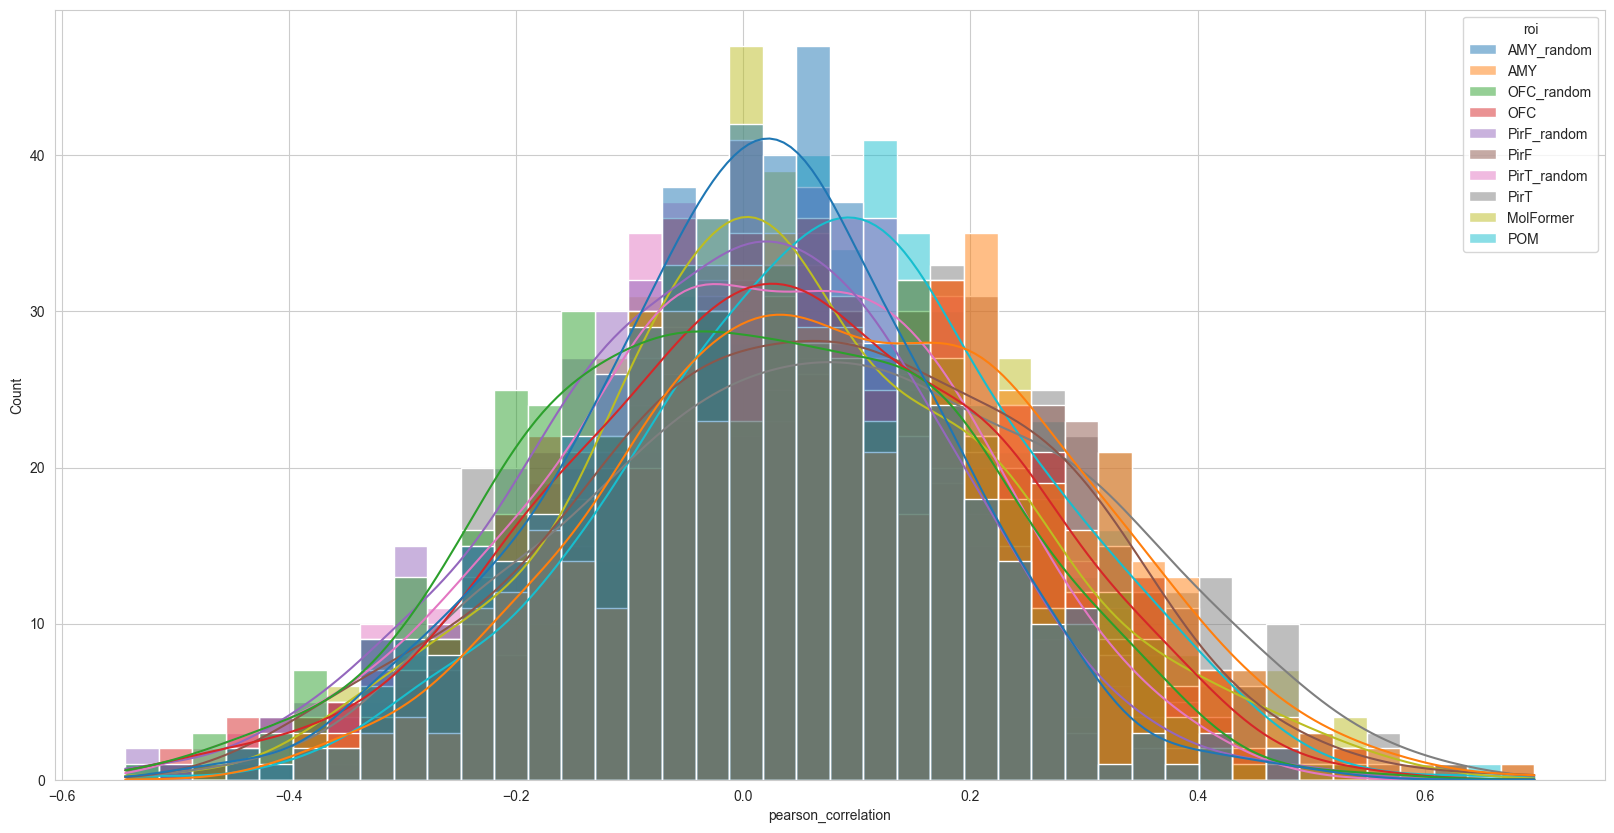

In [12]:
fig,ax= plt.subplots(figsize=(20,10))
sns.histplot(data=df_metrics_all,x='pearson_correlation',hue='roi',ax=ax,kde=True)

<Axes: xlabel='roi', ylabel='mse'>

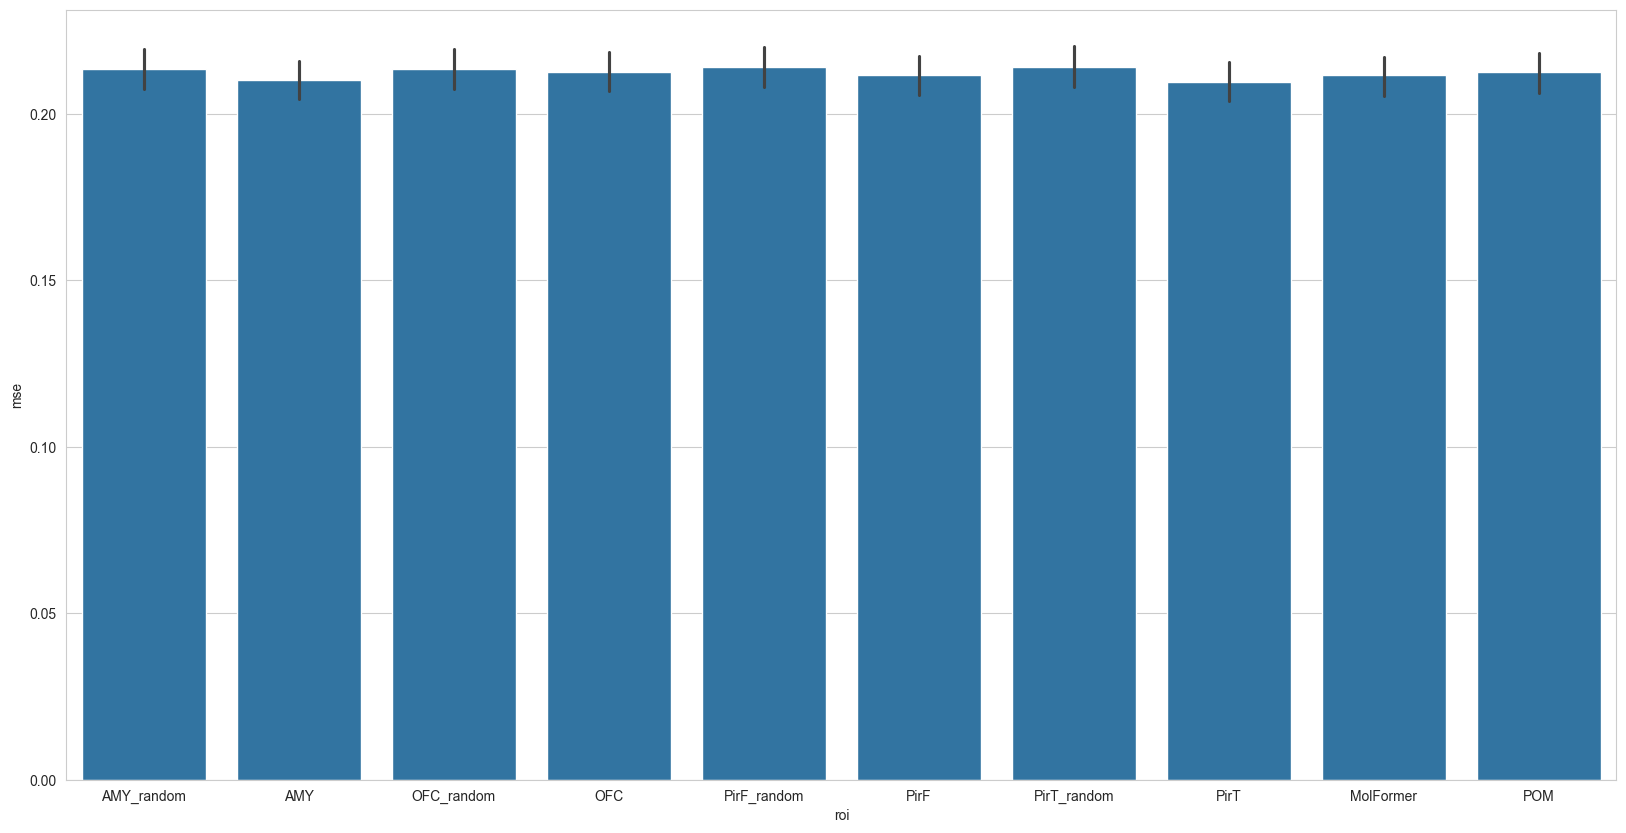

In [13]:
fig,ax= plt.subplots(figsize=(20,10))
sns.barplot(data=df_metrics_all,x='roi',y='mse',ax=ax)

#

<Axes: xlabel='roi', ylabel='pearson_correlation'>

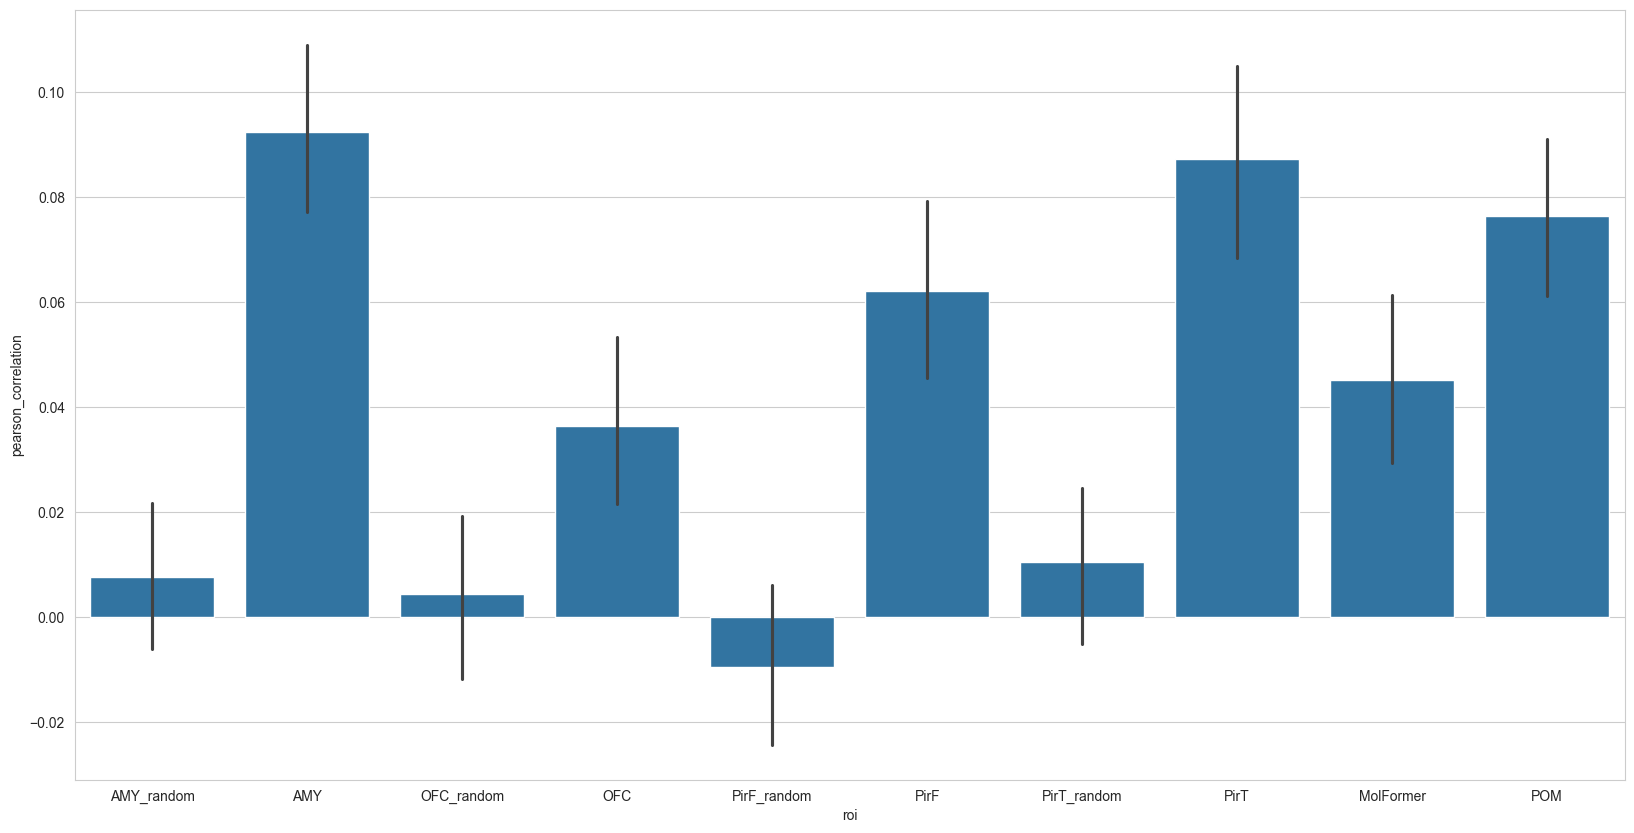

In [14]:
fig,ax= plt.subplots(figsize=(20,10))
sns.barplot(data=df_metrics_all,x='roi',y='pearson_correlation',ax=ax)